<h1>Neural Network</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_boston, make_circles, make_classification, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


from IPython.display import HTML

<h3>Let's define some loss functions we will optimize (with treir derivatives)</h3>

In [2]:
def mse(y_true, y_pred):
    '''
    Compute mean squared error, y_pred - vector of size n_objects
    '''
    return np.mean(np.power(y_true - y_pred, 2))

def mse_derivative(y_true, y_pred):
    '''
    Compute derivative of MSE
    '''
    return -2 * (y_true - y_pred) / len(y_true)

def log_loss(y_true, a_pred):
    '''
    Compute log loss, a_pred - vector of size n_objects
    '''
    return np.mean(-y_true * np.log(a_pred) - (1 - y_true) * np.log(1 - a_pred))

def log_loss_derivative(y_true, a_pred):
    '''
    Compute detivative of log loss
    '''
    return (-y_true / a_pred + (1 - y_true) / (1 - a_pred)) / len(y_true)

def cross_entropy_loss(y_true, a_pred):
    '''
    Compute cross-entropy loss, a_pred - matrix with shape [n_objects; n_classes]
    '''
    loss = 0
    for i, j in enumerate(y_true):
        loss += -np.log(a_pred[i][j[0]])
    return loss

def cross_entropy_loss_derivative(y_true, a_pred):
    '''
    Compute derivative for cross-entropy loss
    '''
    loss = []
    for i, j in enumerate(y_true):
        loss.append(-1 / a_pred[i][j[0]])
    return np.array(loss).reshape(-1, 1)

<h3>Define some activation functions as well</h3>

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = 1 / (1 + np.exp(-z))
    return s * (1 - s)

def tanh(z):
    return np.tanh(z);

def tanh_derivative(z):
    return 1 - np.tanh(z) ** 2;

def RElU(z):
    return np.maximum(0, z)

def RElU_derivative(z):
    return (z > 0).astype(int)

def softmax(z):
    '''
    Softmax function, z - matrix with shape [n_objects; n_classes]
    '''
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

def softmax_grad(z, y_true):
    '''
    Softmax derivative for cross-entropy loss! y_true - vector of true classes
    with shape [n_objects], classes from 0 to n_classes-1
    '''
    s = softmax(z)
    grad = np.zeros(shape=s.shape)
    for obj, target in enumerate(y_true):
        for z in range(len(s[obj])):
            if target == z:
                grad[obj][z] = s[obj][z] * (1 - s[obj][z])
            else:
                grad[obj][z] = -s[obj][target] * s[obj][z]
    return grad

<p>Let's define some typical NN layers</p>

In [4]:
class Linear:
    '''
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    '''
    def __init__(self, n_input, n_output):
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2/(n_input + n_output)), size=(n_input, n_output)) # He initialization
        self.b = np.random.normal(scale=np.sqrt(2/(n_input + n_output)), size=(1, n_output))
        
    def forward(self, x):
        self.input = x
        return x.dot(self.w) + self.b
    
    def backward(self, output_error, learning_rate):
        '''
        Backpropagation
        '''
        w_grad = self.input.T.dot(output_error) # weights gradient
        b_grad = np.ones((1, len(output_error))).dot(output_error) # bias gradient
        input_error = output_error.dot(self.w.T) # error of the input is used as the output_error of the previous layer
        
        #update weights
        self.w -= learning_rate * w_grad
        self.b -= learning_rate * b_grad
        return input_error # return the error for the previous layer
    
    def __repr__(self):
        return f'Linear layer, input size:{self.n_input}, output size:{self.n_output}'
    
class LinearAdam:
    '''
    LinearAdam class permorms ordinary FC layer in neural networks with optimization method ADAM
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate, beta1, beta2, eps) - performs backward pass of the layer with ADAM
    '''
    def __init__(self, n_input, n_output):
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2/(n_input + n_output)), size=(n_input, n_output))
        self.b = np.random.normal(scale=np.sqrt(2/(n_input + n_output)), size=(1, n_output))
        
        self.EMA_adam1_w = np.zeros(shape=(self.w.shape))
        self.EMA_adam2_w = np.zeros(shape=(self.w.shape))
        
        self.EMA_adam1_b = np.zeros(shape=(self.b.shape))
        self.EMA_adam2_b = np.zeros(shape=(self.b.shape))
        
    def forward(self, x):
        self.input = x
        return x.dot(self.w) + self.b
    
    def backward(self, output_error, learning_rate, beta1=0.9, beta2=0.999, eps=10e-9):
        w_grad = self.input.T.dot(output_error)
        b_grad = np.ones((1, len(output_error))).dot(output_error)
        input_error = output_error.dot(self.w.T)
        
        next_EMA1_w = (1 - beta1) * w_grad + beta1 * self.EMA_adam1_w
        next_EMA2_w = (1 - beta2) * w_grad ** 2 + beta2 * self.EMA_adam2_w
        
        next_EMA1_b = (1 - beta1) * b_grad + beta1 * self.EMA_adam1_b
        next_EMA2_b = (1 - beta2) * b_grad ** 2 + beta2 * self.EMA_adam2_b
        
        self.w -= learning_rate * next_EMA1_w / (np.sqrt(next_EMA2_w) + eps)
        self.b -= learning_rate * next_EMA1_b / (np.sqrt(next_EMA2_b) + eps)
        return input_error
    
    def __repr__(self):
        return f'LinearAdam layer, input size:{self.n_input}, output size:{self.n_output}'
    
class Activation:
    '''
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    '''
    def __init__(self, activation_function, activation_derivative):
        self.activation = activation_function
        self.derivative = activation_derivative
        
    def forward(self, x):
        self.input = x
        return self.activation(x)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.derivative(self.input)
    
    def __repr__(self):
        return f'Activation layer, activation function:{self.activation}'
    
class SoftMaxLayer:
    '''
    Class for softmax layer, it needs y_true for initialization, all the rest are the same as "Activation" class
    '''
    def __init__(self, activation_function, activation_derivative, y):
        self.activation = softmax
        self.derivative = softmax_grad
        self.y_true = y
        
    def forward(self, x):
        self.input = x
        return self.activation(x)
    
    def backward(self, output_error, learning_rate):
        return output_error * self.derivative(self.input, self.y_true)   
    
    def __repr__(self):
        return f'SoftMax layer'

In [5]:
class NeuralNetwork:
    '''
    NeuralNetwork class is used to build the Neural Network and train it
    Methods:
    use(loss, loss_derivative) - set the loss function and it's derivative
    add_layer(layer) - constructor of the NN, add one of the layers described above
    predict(x) - forward pass through the network
    fit(x, y, learning_rate, n_epochs, x_val, y_val) - fit the network
    '''
    def __init__(self):
        self.layers = []
        
    def use(self, loss, loss_derivative):
        self.loss = loss
        self.loss_derivative = loss_derivative
        
    def add_layer(self, layer):
        self.layers.append(layer)
        
    def predict(self, x):
        prediction = x
        for layer in self.layers:
            prediction = layer.forward(prediction)
        return prediction
    
    def fit(self, x, y, learning_rate, n_epochs, x_val=None, y_val=None):
        
        loss_print_epoch = n_epochs / 10 # print the loss 10 times
        
        for _ in range(n_epochs):
            preds = self.predict(x) # predict the output
            err = self.loss(y, preds) # calculate the loss, only for printing
            output_error = self.loss_derivative(y, preds) # calculate the error to start backpropagation
            
            for layer in reversed(self.layers):
                output_error = layer.backward(output_error, learning_rate) # backward pass
                
            if x_val is not None and y_val is not None: # print the loss for the validation set
                err_val = self.loss(y_val, self.predict(x_val))
                if _ % loss_print_epoch == 0:
                    print('*' * 30)
                    print(f'Epoch {_}  train_loss:{err}, val_loss:{err_val}')
            else:
                if _ % loss_print_epoch == 0:
                    print('*' * 30)
                    print(f'Epoch {_}  train_loss:{err}')
            
            
        return self
    
    def __repr__(self):
        return f'NeuralNetwork class, layers:\n{self.layers}'

<p>Let's solve the XOR problem first</p>

In [6]:
x_XOR = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_XOR = np.array([[0], [1], [1], [0]])

In [7]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [8]:
nn.fit(x_XOR, y_XOR, 0.1, 1000)

******************************
Epoch 0  train_loss:0.8777893973111146
******************************
Epoch 100  train_loss:0.6539919707622681
******************************
Epoch 200  train_loss:0.6064458275981991
******************************
Epoch 300  train_loss:0.5542767643647216
******************************
Epoch 400  train_loss:0.5086302689956063
******************************
Epoch 500  train_loss:0.4675084412989743
******************************
Epoch 600  train_loss:0.42921276267134434
******************************
Epoch 700  train_loss:0.3722187411967153
******************************
Epoch 800  train_loss:0.2699859604624154
******************************
Epoch 900  train_loss:0.1860759429446058


NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x000001C516309F78>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x000001C516309EE8>]

In [9]:
nn.predict(x_XOR) 

array([[0.04851829],
       [0.85348832],
       [0.8907659 ],
       [0.18918514]])

<p>Looks good, let's try some different tasks</p>

In [10]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 1000)
    x2s = np.linspace(axes[2], axes[3], 1000)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = np.round(clf.predict(X_new)).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][(y==0).reshape(-1)], X[:, 1][(y==0).reshape(-1)], "yo")
        plt.plot(X[:, 0][(y==1).reshape(-1)], X[:, 1][(y==1).reshape(-1)], "bs")
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [11]:
data = load_iris()
x = data['data'][data['target'] != 2][:, 2:4]
y = data['target'][data['target'] != 2].reshape(-1, 1)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [13]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [14]:
nn.fit(x_train, y_train, 0.03, 10000, x_val, y_val)

******************************
Epoch 0  train_loss:1.2299771469586893, val_loss:1.0445729446160579
******************************
Epoch 1000  train_loss:0.030905427320839268, val_loss:0.028708037187993436
******************************
Epoch 2000  train_loss:0.01335886217639902, val_loss:0.012324976309376892
******************************
Epoch 3000  train_loss:0.008330222196550913, val_loss:0.007665591305342452
******************************
Epoch 4000  train_loss:0.006000588457834791, val_loss:0.0055136540670366685
******************************
Epoch 5000  train_loss:0.004668913315983836, val_loss:0.004285787871393541
******************************
Epoch 6000  train_loss:0.003811142375495775, val_loss:0.0034958781801886925
******************************
Epoch 7000  train_loss:0.003214233034179562, val_loss:0.0029467138490258645
******************************
Epoch 8000  train_loss:0.0027757299330024823, val_loss:0.0025435892715019786
******************************
Epoch 9000  train_

NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x000001C516309F78>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x000001C516309EE8>]

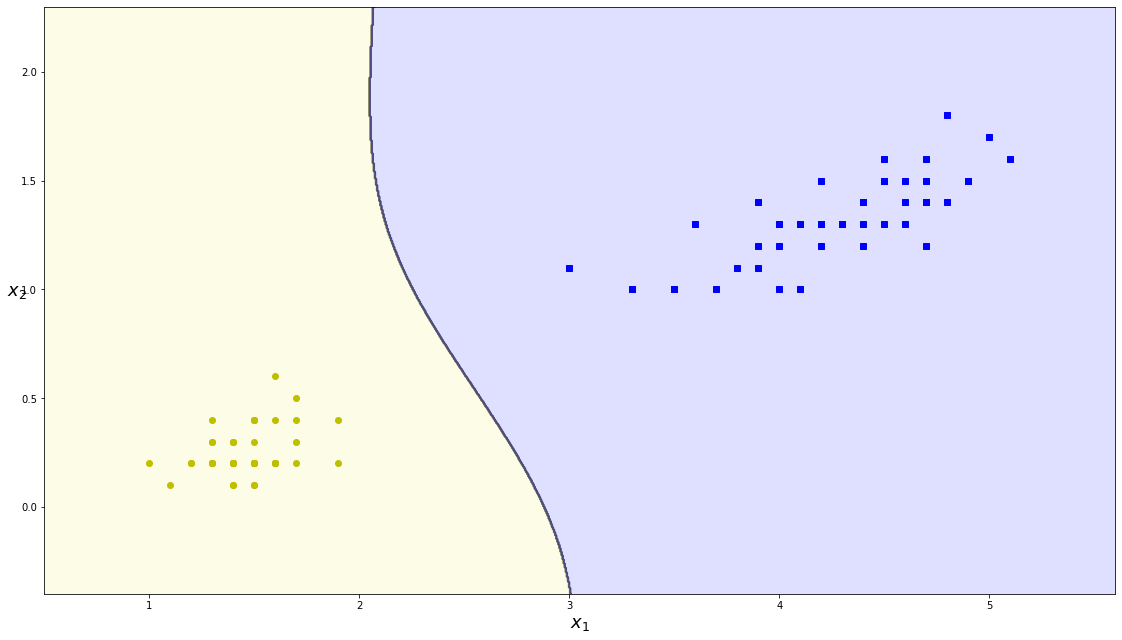

In [15]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

In [16]:
x, y = make_circles(n_samples=1000, noise=0.1, factor=0.5)
y = y.reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [17]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [18]:
nn.fit(x_train, y_train, 0.03, 20000, x_val, y_val)

******************************
Epoch 0  train_loss:0.7194866559273387, val_loss:0.752903097344307
******************************
Epoch 2000  train_loss:0.6776109130296761, val_loss:0.6879673065051941
******************************
Epoch 4000  train_loss:0.5707059614245958, val_loss:0.5669928090650037
******************************
Epoch 6000  train_loss:0.3010431107799569, val_loss:0.29695201675867205
******************************
Epoch 8000  train_loss:0.18468748567469837, val_loss:0.18195054994329365
******************************
Epoch 10000  train_loss:0.14499047944055676, val_loss:0.14381397633218196
******************************
Epoch 12000  train_loss:0.12540756874108555, val_loss:0.12526777363266098
******************************
Epoch 14000  train_loss:0.11310428056363621, val_loss:0.11372075380054594
******************************
Epoch 16000  train_loss:0.10414955239779723, val_loss:0.10536161657612747
******************************
Epoch 18000  train_loss:0.09705572096151

NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x000001C516309F78>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x000001C516309EE8>]

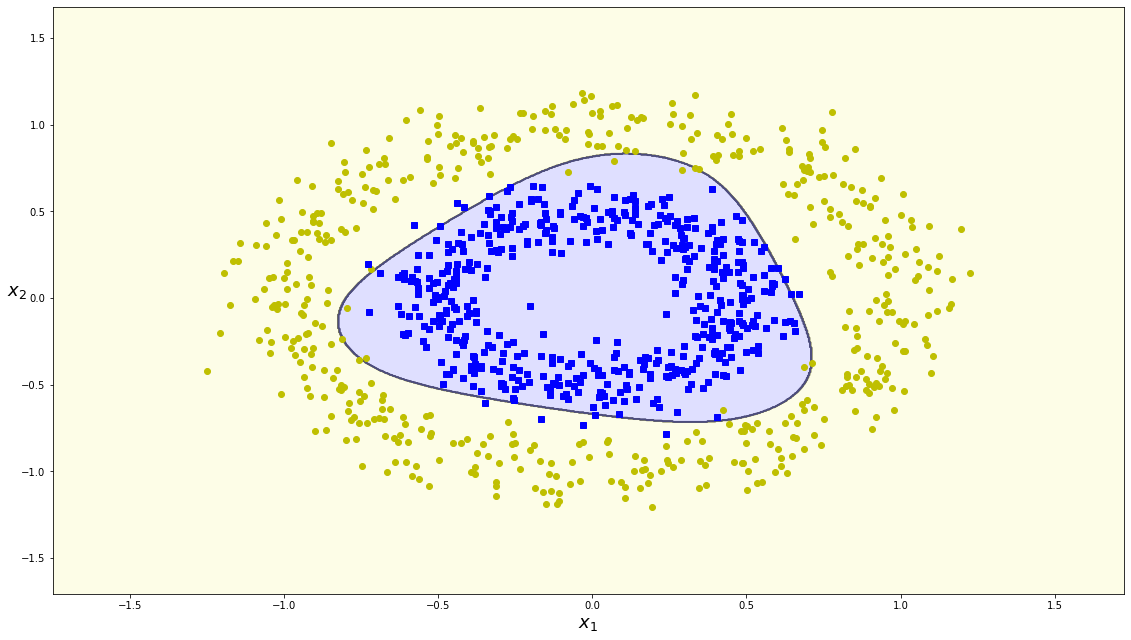

In [19]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

In [20]:
x, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, shift=0.1)
y = y.reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [21]:
nn = NeuralNetwork()
nn.use(log_loss, log_loss_derivative)
nn.add_layer(Linear(2, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 1))
nn.add_layer(Activation(sigmoid, sigmoid_derivative))

In [22]:
nn.fit(x_train, y_train, 0.03, 10000, x_val, y_val)

******************************
Epoch 0  train_loss:0.47392075134001693, val_loss:0.44110784841678474
******************************
Epoch 1000  train_loss:0.29947847672234623, val_loss:0.2491865164304509
******************************
Epoch 2000  train_loss:0.2982295341111096, val_loss:0.24599204427684415
******************************
Epoch 3000  train_loss:0.297660123320375, val_loss:0.24460742612359831
******************************
Epoch 4000  train_loss:0.29729653236436115, val_loss:0.2437757286375561
******************************
Epoch 5000  train_loss:0.2970252302437922, val_loss:0.24322184521196535
******************************
Epoch 6000  train_loss:0.296805602986267, val_loss:0.24283096770896406
******************************
Epoch 7000  train_loss:0.2966194679943035, val_loss:0.24254346764079182
******************************
Epoch 8000  train_loss:0.29645700947958786, val_loss:0.24232526070514013
******************************
Epoch 9000  train_loss:0.29631214745679163, v

NeuralNetwork class, layers:
[Linear layer, input size:2, output size:4, Activation layer, activation function:<function tanh at 0x000001C516309F78>, Linear layer, input size:4, output size:1, Activation layer, activation function:<function sigmoid at 0x000001C516309EE8>]

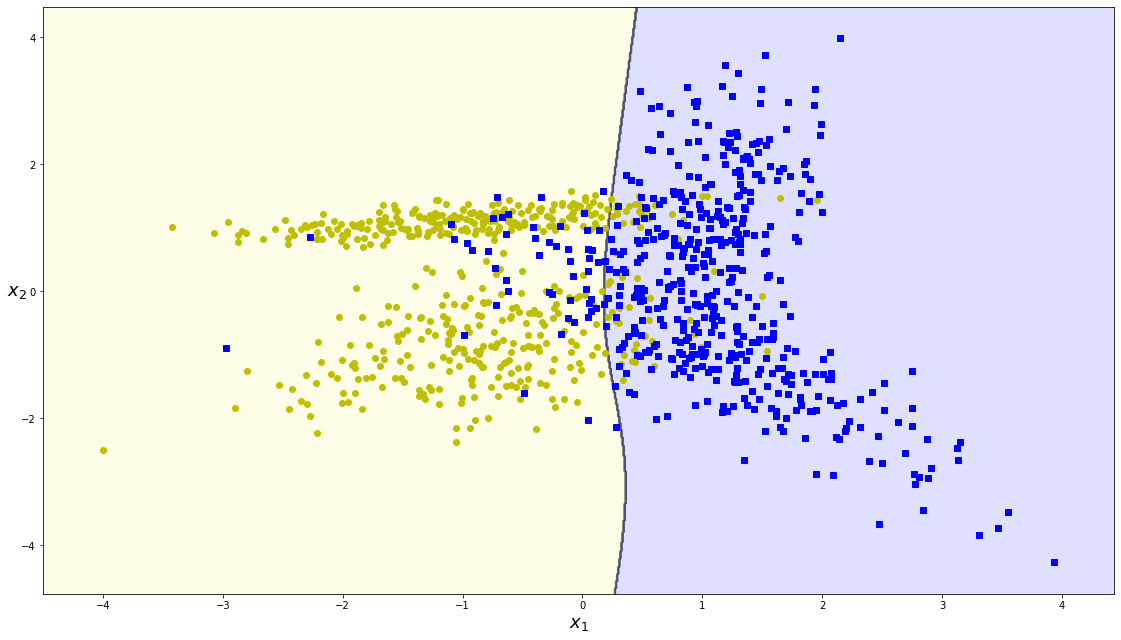

In [23]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

<p>Let's try some multiclass tasks with softmax!</p>

In [24]:
def plot_decision_boundary_for_3_classes(clf, X, y, axes=[0, 7.5, 0, 3], plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 1000)
    x2s = np.linspace(axes[2], axes[3], 1000)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = np.argmax(clf.predict(X_new), axis=1).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][(y==0).reshape(-1)], X[:, 1][(y==0).reshape(-1)], "yo")
        plt.plot(X[:, 0][(y==1).reshape(-1)], X[:, 1][(y==1).reshape(-1)], "bs")
        plt.plot(X[:, 0][(y==2).reshape(-1)], X[:, 1][(y==2).reshape(-1)], "g^")
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

    
def plot_decision_boundary_for_4_classes(clf, X, y, axes=[0, 7.5, 0, 3], plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 1000)
    x2s = np.linspace(axes[2], axes[3], 1000)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = np.argmax(clf.predict(X_new), axis=1).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0', '#8B0000'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50', '#8B0000'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][(y==0).reshape(-1)], X[:, 1][(y==0).reshape(-1)], "yo")
        plt.plot(X[:, 0][(y==1).reshape(-1)], X[:, 1][(y==1).reshape(-1)], "bs")
        plt.plot(X[:, 0][(y==2).reshape(-1)], X[:, 1][(y==2).reshape(-1)], "g^")
        plt.plot(X[:, 0][(y==3).reshape(-1)], X[:, 1][(y==3).reshape(-1)], "r*")
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [25]:
data = load_iris()
x = data['data'][:, 2:4]
y = data['target'].reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [26]:
nn = NeuralNetwork()
nn.use(cross_entropy_loss, cross_entropy_loss_derivative)
nn.add_layer(Linear(2, 16))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(16, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 4))
nn.add_layer(SoftMaxLayer(softmax, softmax_grad, y_train))

In [27]:
nn.fit(x_train, y_train, 0.0003, 10000, x_val, y_val)

******************************
Epoch 0  train_loss:153.8682493480364, val_loss:74.3552717919871
******************************
Epoch 1000  train_loss:16.108181107459014, val_loss:6.805663964704803
******************************
Epoch 2000  train_loss:11.746531776794018, val_loss:4.149746673036495
******************************
Epoch 3000  train_loss:10.470972719976796, val_loss:3.0129740616135954
******************************
Epoch 4000  train_loss:9.914729648427524, val_loss:2.5372696950578395
******************************
Epoch 5000  train_loss:9.63189645192575, val_loss:2.336305344485
******************************
Epoch 6000  train_loss:9.477097473907847, val_loss:2.246608526367362
******************************
Epoch 7000  train_loss:9.38213679579171, val_loss:2.198431294907614
******************************
Epoch 8000  train_loss:9.313628248948698, val_loss:2.1670814912238914
******************************
Epoch 9000  train_loss:9.2599312917948, val_loss:2.145184250615509


NeuralNetwork class, layers:
[Linear layer, input size:2, output size:16, Activation layer, activation function:<function tanh at 0x000001C516309F78>, Linear layer, input size:16, output size:4, Activation layer, activation function:<function tanh at 0x000001C516309F78>, Linear layer, input size:4, output size:4, SoftMax layer]

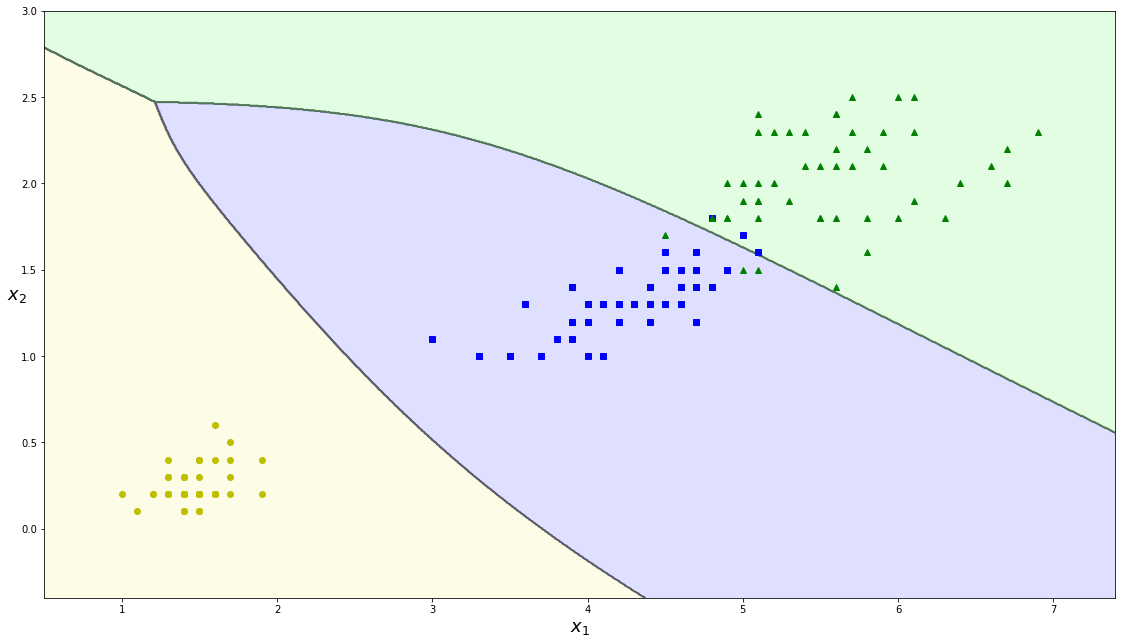

In [28]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary_for_3_classes(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

In [29]:
x, y = make_classification(n_samples=100, n_features=2, n_redundant=0, shift=0.5, n_classes=4, n_clusters_per_class=1)
y = y.reshape(-1, 1)

In [30]:
nn = NeuralNetwork()
nn.use(cross_entropy_loss, cross_entropy_loss_derivative)
nn.add_layer(Linear(2, 16))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(16, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(4, 4))
nn.add_layer(SoftMaxLayer(softmax, softmax_grad, y))

In [31]:
nn.fit(x, y, 0.0003, 10000)

******************************
Epoch 0  train_loss:152.42425541682402
******************************
Epoch 1000  train_loss:12.93024435974433
******************************
Epoch 2000  train_loss:7.243199199969162
******************************
Epoch 3000  train_loss:5.303256112101173
******************************
Epoch 4000  train_loss:4.309194056686521
******************************
Epoch 5000  train_loss:3.6762166182622584
******************************
Epoch 6000  train_loss:3.2198210454855274
******************************
Epoch 7000  train_loss:2.866027593531813
******************************
Epoch 8000  train_loss:2.580166034268509
******************************
Epoch 9000  train_loss:2.3429829093269006


NeuralNetwork class, layers:
[Linear layer, input size:2, output size:16, Activation layer, activation function:<function tanh at 0x000001C516309F78>, Linear layer, input size:16, output size:4, Activation layer, activation function:<function tanh at 0x000001C516309F78>, Linear layer, input size:4, output size:4, SoftMax layer]

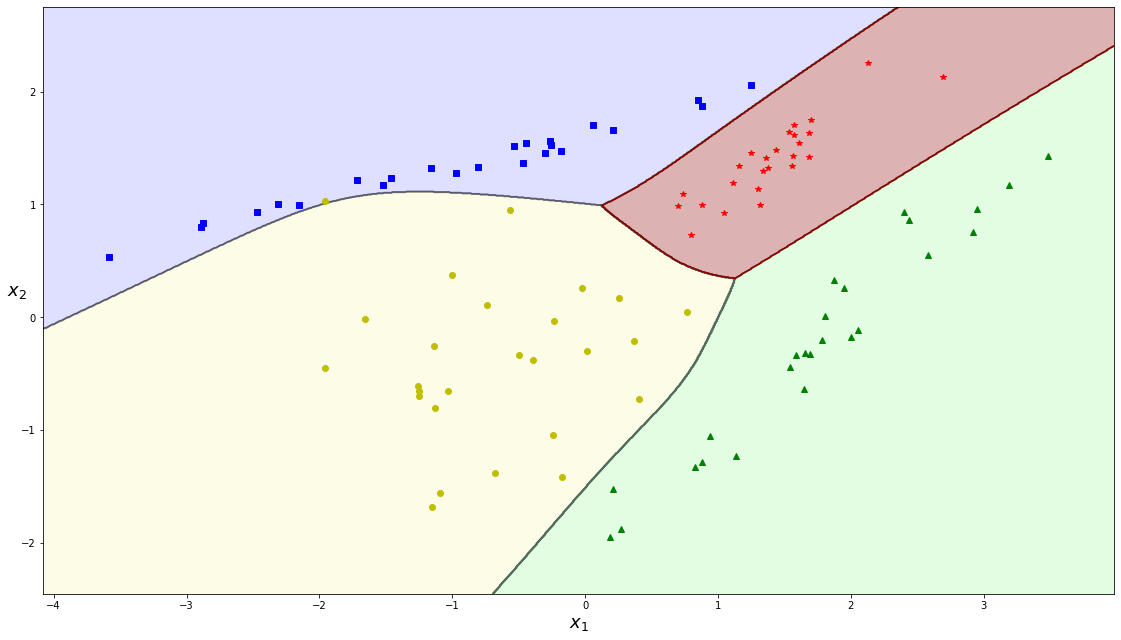

In [32]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary_for_4_classes(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

<p>Some classification using ADAM</p>

In [33]:
x, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, shift=0.5, n_classes=4, n_clusters_per_class=1)
y = y.reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [34]:
nn = NeuralNetwork()
nn.use(cross_entropy_loss, cross_entropy_loss_derivative)
nn.add_layer(LinearAdam(2, 16))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(LinearAdam(16, 4))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(LinearAdam(4, 4))
nn.add_layer(SoftMaxLayer(softmax, softmax_grad, y_train))

In [35]:
nn.fit(x_train, y_train, 3e-4, 10000, x_val, y_val)

******************************
Epoch 0  train_loss:1148.6544158756537, val_loss:546.556368814107
******************************
Epoch 1000  train_loss:293.7628143345174, val_loss:149.15470853122537
******************************
Epoch 2000  train_loss:270.2716684159787, val_loss:156.75720416165424
******************************
Epoch 3000  train_loss:266.2165007711418, val_loss:158.71445878610294
******************************
Epoch 4000  train_loss:265.7148211493474, val_loss:159.05328568240932
******************************
Epoch 5000  train_loss:265.71474383951625, val_loss:159.05317974422988
******************************
Epoch 6000  train_loss:265.71466644660325, val_loss:159.05302083207653
******************************
Epoch 7000  train_loss:265.7145897160033, val_loss:159.05285254252064
******************************
Epoch 8000  train_loss:265.71451397591073, val_loss:159.05268788302547
******************************
Epoch 9000  train_loss:265.71443927240693, val_loss:159.05253

NeuralNetwork class, layers:
[LinearAdam layer, input size:2, output size:16, Activation layer, activation function:<function tanh at 0x000001C516309F78>, LinearAdam layer, input size:16, output size:4, Activation layer, activation function:<function tanh at 0x000001C516309F78>, LinearAdam layer, input size:4, output size:4, SoftMax layer]

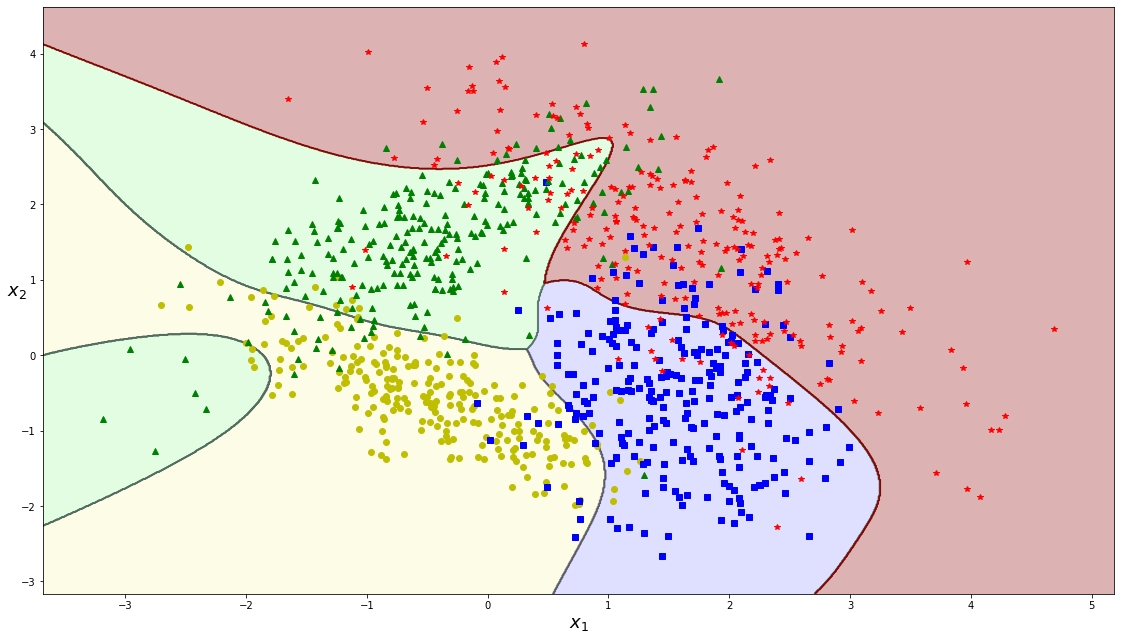

In [36]:
plt.figure(figsize=(19.20, 10.80))
plot_decision_boundary_for_4_classes(nn, x, y, axes = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5,\
                                           x[:, 1].min() - 0.5, x[:, 1].max() + 0.5])

plt.show()

<p>Some regression</p>

In [37]:
scaler = StandardScaler()

In [38]:
data = load_boston()
x = scaler.fit_transform(data['data'])
y = data['target'].reshape(-1, 1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [39]:
nn = NeuralNetwork()
nn.use(mse, mse_derivative)
nn.add_layer(Linear(13, 6))
nn.add_layer(Activation(tanh, tanh_derivative))
nn.add_layer(Linear(6, 1))

In [40]:
nn.fit(x_train, y_train, 0.03, 1000, x_val, y_val)

******************************
Epoch 0  train_loss:616.7119557566828, val_loss:449.42248465993003
******************************
Epoch 100  train_loss:16.16925337742821, val_loss:19.488283077025887
******************************
Epoch 200  train_loss:11.72176954198788, val_loss:17.357896165262797
******************************
Epoch 300  train_loss:10.170118219247062, val_loss:19.001328290221267
******************************
Epoch 400  train_loss:9.443665788036704, val_loss:19.520319892489894
******************************
Epoch 500  train_loss:9.17092770496058, val_loss:19.625831938396313
******************************
Epoch 600  train_loss:8.904482181819876, val_loss:19.598129456964546
******************************
Epoch 700  train_loss:8.655236838515073, val_loss:19.608984797246936
******************************
Epoch 800  train_loss:8.497556994305826, val_loss:19.583642533249474
******************************
Epoch 900  train_loss:8.373684682893806, val_loss:19.502273041242034


NeuralNetwork class, layers:
[Linear layer, input size:13, output size:6, Activation layer, activation function:<function tanh at 0x000001C516309F78>, Linear layer, input size:6, output size:1]

In [41]:
print(r2_score(y_val, nn.predict(x_val)))

0.722399457707888


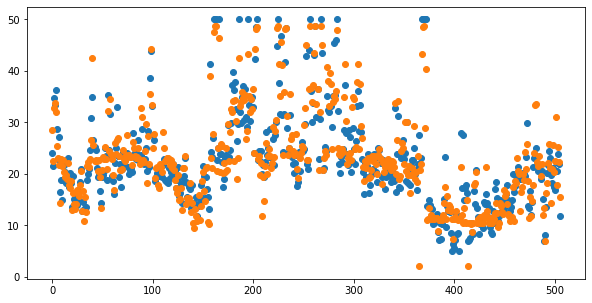

In [42]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y)), y)
plt.scatter(range(len(y)), nn.predict(x))
plt.show()

In [43]:
with open('./style.css') as f:
    style = f.read()
HTML(style)